In [1]:
from transformers import (
    HubertForSequenceClassification,
    Wav2Vec2FeatureExtractor,
)

import librosa
import numpy as np
import pandas as pd
import torch

In [2]:
models_list = [
    "models/2000-samples/hubert-base-dusha-ft-0-layers",
    "models/2000-samples/hubert-base-dusha-ft-12-layers",
    "models/2000-samples/hubert-base-dusha-ft-12-layers-5ep",
    "models/2000-samples/hubert-base-dusha-ft-12-layers-10ep",
    "models/2000-samples/hubert-base-dusha-ft-12-layers-15ep",
    "models/8000-samples/hubert-base-dusha-ft-12-layers-3ep-8k",
    "models/8000-samples/hubert-base-dusha-ft-12-layers-5ep-8k",
]

In [62]:
model_id = models_list[-1]

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
model = HubertForSequenceClassification.from_pretrained(
    model_id,
    local_files_only=True,
    output_hidden_states=True
)

In [4]:
labels_names = ["neutral", "angry", "positive", "sad"]
sampling_rate = feature_extractor.sampling_rate

# predictions = torch.argmax(output.logits, dim=-1)
# print(labels_names[predictions.numpy()[0]])

In [5]:
df = pd.read_csv("../data/crowd_test_500.csv")
df.head()

,id,audio_path,features_path,emotion,label,duration
0,9e9961c53ca6eeb440b217e539fbf46c,dusha/crowd/crowd_test/wavs/9e9961c53ca6eeb440...,dusha/features/9e9961c53ca6eeb440b217e539fbf46...,neutral,0,5.82
1,0166f65a30354db8282682b1a280e64c,dusha/crowd/crowd_test/wavs/0166f65a30354db828...,dusha/features/0166f65a30354db8282682b1a280e64...,neutral,0,3.70
2,d49a6b560155831725a7bdc7d0a96099,dusha/crowd/crowd_test/wavs/d49a6b560155831725...,dusha/features/d49a6b560155831725a7bdc7d0a9609...,neutral,0,4.38
3,c6852b0925797612d7b6724da8cbe7b4,dusha/crowd/crowd_test/wavs/c6852b0925797612d7...,dusha/features/c6852b0925797612d7b6724da8cbe7b...,neutral,0,8.58
4,64a7aa17132c3e4b7be1aaed5fc88090,dusha/crowd/crowd_test/wavs/64a7aa17132c3e4b7b...,dusha/features/64a7aa17132c3e4b7be1aaed5fc8809...,positive,2,5.06


In [6]:
n_samples = 20
df_reduce = df.groupby(['emotion']).head(n_samples).reset_index(drop=True)
df_reduce[['emotion']].groupby('emotion').value_counts()

emotion
angry       20
neutral     20
positive    20
sad         20
Name: count, dtype: int64

In [59]:
# Получение выхода с модели
def get_output_for_audio(audio, feature_extractor, model, sampling_rate=16000):
    audio_array = librosa.load(
        audio,
        sr=sampling_rate,
        mono=False
    )[0]
    
    input_values = feature_extractor(
        audio_array,
        sampling_rate=sampling_rate,
        return_tensors="pt"
    ).input_values

    output = model(input_values)

    return output

# Получение массива со средними значениями признаков каждого аудиофайла
def get_mean_features_and_labels(df, model, feature_extractor, sampling_rate=16000):
    output = get_output_for_audio(f'../{df["audio_path"][0]}', feature_extractor, model, sampling_rate)
    hidden_state = output.hidden_states[-1].detach().numpy()[0]
    hidden_state = hidden_state.mean(axis=0)

    features_list = [[hidden_state]]
    labels_list = [df['label'][0]]

    for index, row in df.iterrows():
        if (index == 0):
            continue
        
        output = get_output_for_audio(f'../{row["audio_path"]}', feature_extractor, model, sampling_rate)
        hidden_state = output.hidden_states[-1].detach().numpy()[0]
        hidden_state = hidden_state.mean(axis=0)
        
        features_list.append([hidden_state])
        labels_list.append(row['label'])
    
    data = np.concatenate(features_list)
    labels = np.array(labels_list)
    
    return data, labels

# Получение массива со значениями признаков
def get_features_and_labels(df, model, feature_extractor, sampling_rate=16000):
    output = get_output_for_audio(f'../{df["audio_path"][0]}', feature_extractor, model, sampling_rate)
    hidden_state = output.hidden_states[-1].detach().numpy()[0]
    
    features_list = [hidden_state]
    labels_list = [[df['label'][0] for _ in range(hidden_state.shape[0])]]

    for index, row in df.iterrows():
        if (index == 0):
            continue
        
        output = get_output_for_audio(f'../{row["audio_path"]}', feature_extractor, model, sampling_rate)
        hidden_state = output.hidden_states[-1].detach().numpy()[0]

        features_list.append(hidden_state)
        labels_list.append([row['label'] for _ in range(hidden_state.shape[0])])
    
    data = np.concatenate(features_list)
    labels = np.concatenate(labels_list)
    
    return data, labels

In [63]:
# data, labels = get_features_and_labels(df_reduce, model, feature_extractor, sampling_rate)
data, labels = get_mean_features_and_labels(df_reduce, model, feature_extractor, sampling_rate)

## Визуализация результатов

In [55]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sns.set()

import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [56]:
import matplotlib as mpl
import matplotlib.colors as mcolors

def color_map_color(value, cmap_name='viridis', vmin=0, vmax=1):
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = mpl.colormaps[cmap_name]
    rgb = cmap(norm(abs(value)))[:3]
    color = mcolors.rgb2hex(rgb)
    return color

def get_patches(colormap='viridis'):
    pathches = [
        mpatches.Patch(color=color_map_color(0, colormap, 0, 3), label='neutral'),
        mpatches.Patch(color=color_map_color(1, colormap, 0, 3), label='angry'),
        mpatches.Patch(color=color_map_color(2, colormap, 0, 3), label='positive'),
        mpatches.Patch(color=color_map_color(3, colormap, 0, 3), label='sad'),
    ]

    return pathches

def plot_2d(data, labels, title=""):
    pca_2d = PCA(n_components=2)
    pca_2d_data = pca_2d.fit_transform(data)

    fig, ax = plt.subplots()
    ax.scatter(x=pca_2d_data[:, 0], y=pca_2d_data[:, 1], c=labels, cmap='viridis')
    
    ax.legend(handles=get_patches())
    ax.set_title(title)
    
    plt.show()

def plot_3d(data, labels, title=""):
    pca_3d = PCA(n_components=3)
    pca_3d_data = pca_3d.fit_transform(data)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    ax.scatter(xs=pca_3d_data[:, 0], ys=pca_3d_data[:, 1], zs=pca_3d_data[:, 2], c=labels, cmap='viridis')
    ax.legend(handles=get_patches())
    ax.set_title(title)
        
    plt.show()

## 2D

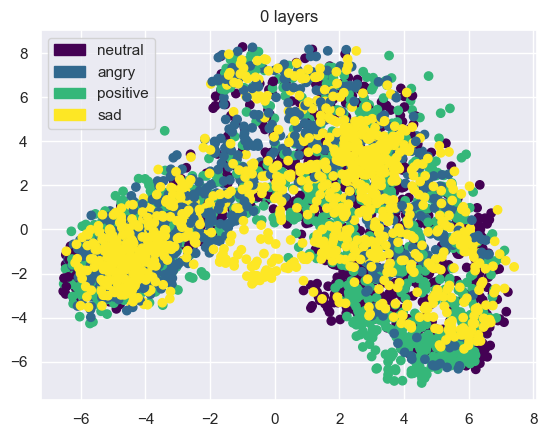

In [42]:
plot_2d(data, labels, "0 layers")

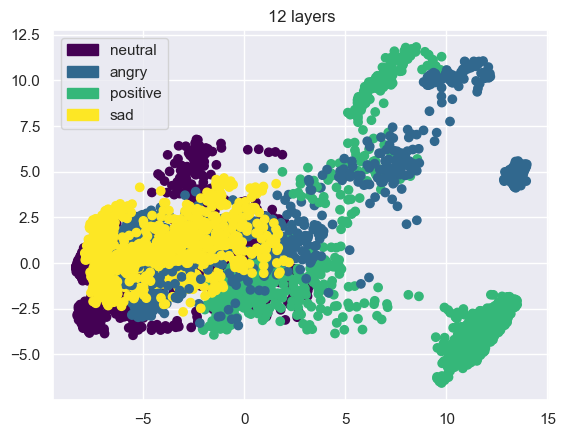

In [35]:
plot_2d(data, labels, "12 layers")

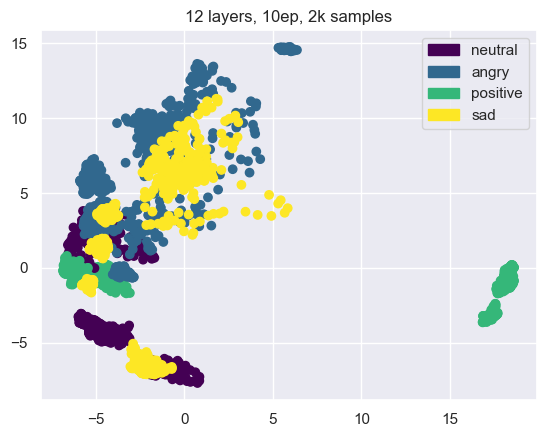

In [47]:
plot_2d(data, labels, "12 layers, 10ep, 2k samples")

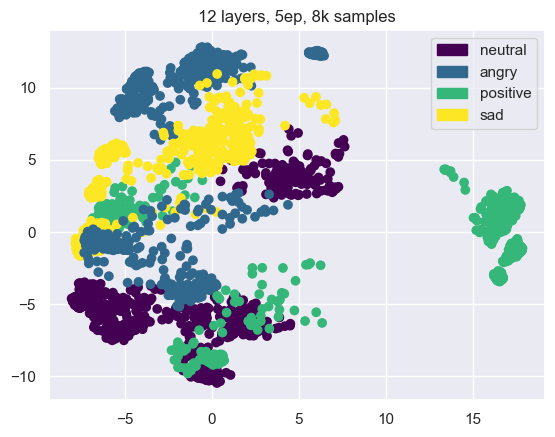

In [51]:
plot_2d(data, labels, "12 layers, 5ep, 8k samples")

## 3D

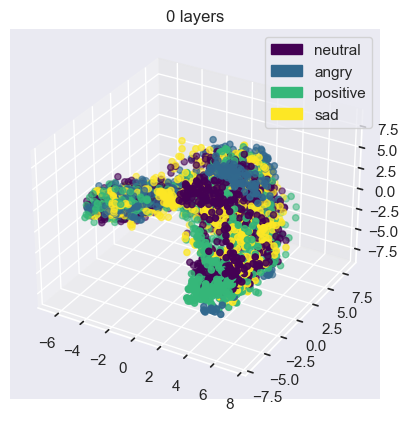

In [43]:
plot_3d(data, labels, "0 layers")

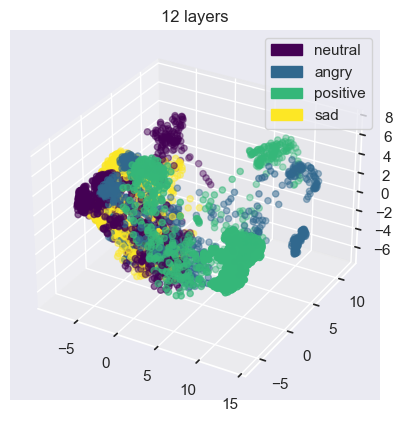

In [37]:
plot_3d(data, labels, "12 layers")

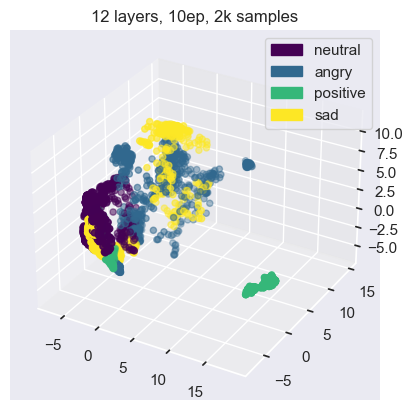

In [48]:
plot_3d(data, labels, "12 layers, 10ep, 2k samples")

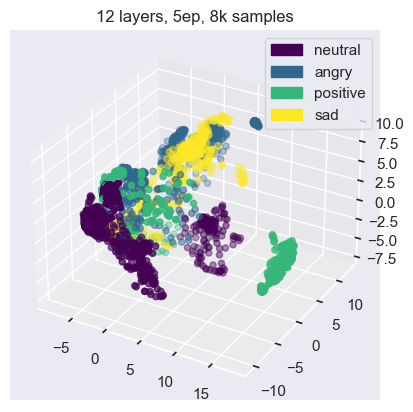

In [52]:
plot_3d(data, labels, "12 layers, 5ep, 8k samples")

### Средние значения признаков

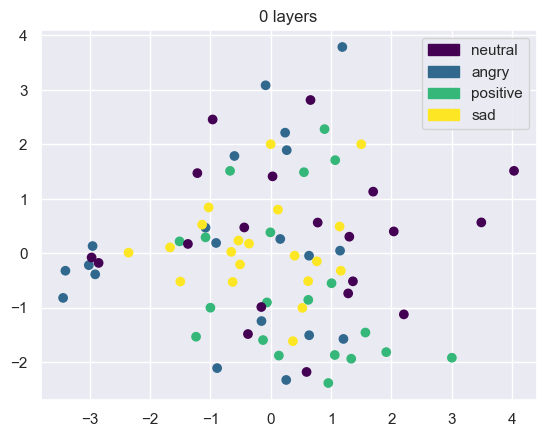

In [57]:
plot_2d(data, labels, "0 layers")

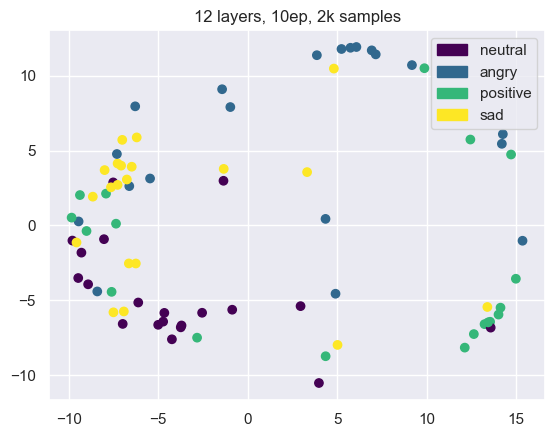

In [61]:
plot_2d(data, labels, "12 layers, 10ep, 2k samples")

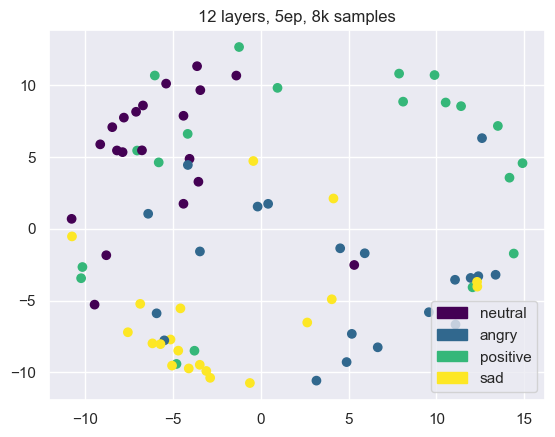

In [64]:
plot_2d(data, labels, "12 layers, 5ep, 8k samples")